In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor


In [4]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [5]:
df = pd.read_csv('data/students.csv')

In [6]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [7]:
#Independent(X) and Dependent(y) variables
X = df.drop(columns=['math_score'],axis=1)
y = df['math_score']

In [8]:
X

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75
...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,99,95
996,male,group C,high school,free/reduced,none,55,55
997,female,group C,high school,free/reduced,completed,71,65
998,female,group D,some college,standard,completed,78,77


In [10]:
numerical_features = X.select_dtypes(exclude='object').columns
categorical_features = X.select_dtypes(include='object').columns

In [11]:
numerical_features

Index(['reading_score', 'writing_score'], dtype='object')

In [12]:
categorical_features

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course'],
      dtype='object')

In [14]:
#Exploring data
print("Categories in 'gender' variable: ", end=" " )
print(df['gender'].unique())

print("Categories in 'race/ethnicity' variable: ", end=" ")
print(df['race_ethnicity'].unique())

print("Categories in 'parental level of education' variable:", end=" " )
print(df['parental_level_of_education'].unique())

print("Categories in 'lunch' variable: ", end=" " )
print(df['lunch'].unique())

print("Categories in 'test preparation course' variable: ", end=" " )
print(df['test_preparation_course'].unique())


Categories in 'gender' variable:  ['female' 'male']
Categories in 'race/ethnicity' variable:  ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in 'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:  ['standard' 'free/reduced']
Categories in 'test preparation course' variable:  ['none' 'completed']


In [15]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
numeric_transform = StandardScaler()
one_hot_transform =  OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder",one_hot_transform,categorical_features),
        ("StandardScaler",numeric_transform,numerical_features)
    ]
)

In [16]:
X = preprocessor.fit_transform(X)

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
def evaluate_model(true,predicted,n_samples,n_features):
    mae = mean_absolute_error(true,predicted)
    mse = mean_squared_error(true,predicted)
    rmse = np.sqrt(mse)
    r2Score = r2_score(true,predicted)
    adj_r2 = 1 - (1 - r2Score) * (n_samples - 1) / (n_samples - n_features - 1)

    return mae,mse,rmse,r2Score,adj_r2


In [19]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "SVR": SVR(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "KNN": KNeighborsRegressor(),
    "CatBoost": CatBoostRegressor(verbose=0)
}
n_train, n_features = X_train.shape  
n_test = X_test.shape[0]             


results = {}

for name, model in models.items():
    model.fit(X_train, y_train)         

    # Train evaluation
    y_train_pred = model.predict(X_train)
    train_mae, train_mse, train_rmse, train_r2, train_adj_r2 = evaluate_model(
        y_train, y_train_pred, n_train, n_features
    )

    # Test evaluation
    y_test_pred = model.predict(X_test)
    test_mae, test_mse, test_rmse, test_r2, test_adj_r2 = evaluate_model(
        y_test, y_test_pred, n_test, n_features
    )

    results[name] = {
        "Train_R2": train_r2, "Train_AdjR2": train_adj_r2,
        "Train_RMSE": train_rmse, "Train_MAE": train_mae,
        "Test_R2": test_r2, "Test_AdjR2": test_adj_r2,
        "Test_RMSE": test_rmse, "Test_MAE": test_mae
    }


results_df = pd.DataFrame(results).T
pd.set_option('display.width', None)           # no wrapping
pd.set_option('display.max_columns', None)     # show all columns
pd.set_option('display.expand_frame_repr', False)  # prevent line breaks
pd.set_option('display.float_format', '{:.3f}'.format)  # round decimals

results_df = results_df.sort_values(by="Test_R2", ascending=False)

print(results_df)

                  Train_R2  Train_AdjR2  Train_RMSE  Train_MAE  Test_R2  Test_AdjR2  Test_RMSE  Test_MAE
Ridge                0.874        0.871       5.323      4.265    0.881       0.868      5.390     4.211
LinearRegression     0.874        0.871       5.323      4.267    0.880       0.868      5.394     4.215
GradientBoosting     0.905        0.903       4.627      3.723    0.872       0.859      5.578     4.308
RandomForest         0.976        0.976       2.303      1.837    0.853       0.837      5.987     4.616
CatBoost             0.959        0.958       3.043      2.405    0.852       0.836      6.009     4.613
AdaBoost             0.851        0.848       5.792      4.780    0.850       0.834      6.041     4.718
XGBoost              0.995        0.995       1.007      0.687    0.828       0.810      6.473     5.058
Lasso                0.807        0.802       6.594      5.206    0.825       0.807      6.520     5.158
KNN                  0.855        0.852       5.708    

In [20]:
linear_model = LinearRegression(fit_intercept=True)
linear_model = linear_model.fit(X_train,y_train)
y_prdt = linear_model.predict(X_test)
print("The R2-Score is: ",r2_score(y_test,y_prdt))

The R2-Score is:  0.8804332983749565


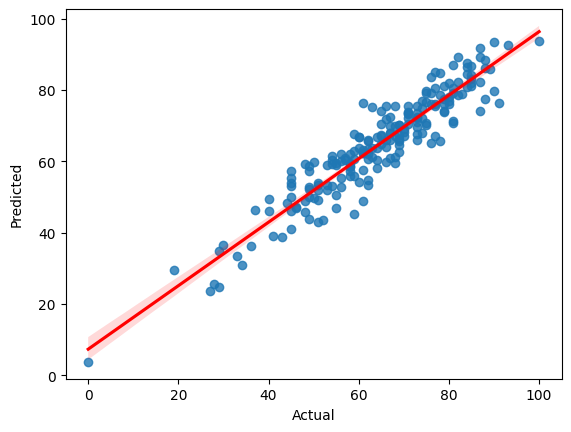

In [24]:
sns.regplot(x=y_test, y=y_prdt, line_kws={'color':'red'})
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [27]:
prdt_df = pd.DataFrame({
    'Predicted':y_prdt,
    'Actual':y_test,
    'Difference':y_test-y_prdt
})
prdt_df

,Predicted,Actual,Difference
521,76.388,91,14.612
737,58.886,53,-5.886
740,76.990,80,3.010
660,76.852,74,-2.852
411,87.627,84,-3.627
...,...,...,...
408,43.409,52,8.591
332,62.152,62,-0.152
208,67.888,74,6.112
613,67.022,65,-2.022
